In [734]:
import torch
import matplotlib.pyplot as plt
from graphxai.datasets import ShapeGGen

In [735]:
dataset = ShapeGGen(
    model_layers = 2,
    num_subgraphs = 15,
    subgraph_size = 13,
    prob_connection = 0.3,
    add_sensitive_feature = False
)


100%|██████████| 54/54 [00:00<00:00, 748.70it/s]


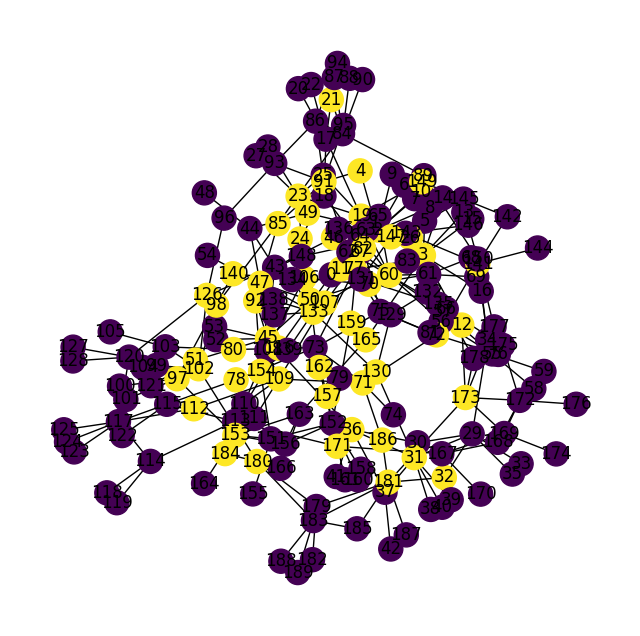

In [736]:
plt.figure(figsize = (8, 8))
dataset.visualize(show = True)

In [737]:
from torch_geometric.nn import GCNConv

class MyGNN(torch.nn.Module):
    def __init__(self, input_feat, hidden_channels, classes = 2):
        super(MyGNN, self).__init__()
        self.gin1 = GCNConv(input_feat, hidden_channels)
        self.gin2 = GCNConv(hidden_channels, classes)

    def forward(self, x, edge_index):
        # NOTE: our provided testing function assumes no softmax
        #   output from the forward call.
        x = self.gin1(x, edge_index)
        x = x.relu()
        x = self.gin2(x, edge_index)
        return x

In [738]:
from graphxai.gnn_models.node_classification import train, test

data = dataset.get_graph(use_fixed_split=True)

model = MyGNN(dataset.n_features, 32)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train model:
for _ in range(1000):
    loss = train(model, optimizer, criterion, data)

# Final testing performance:
f1, acc, prec, rec, auprc, auroc = test(model, data, num_classes = 2, get_auc = True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))

Test F1 score: 0.7500
Test AUROC: 0.9231


In [739]:
data

Data(x=[190, 10], edge_index=[2, 518], y=[190], shape=[190], train_mask=[190], valid_mask=[190], test_mask=[190])

In [740]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    explanation_type=(
        "model"
    ),
    algorithm=GNNExplainer(
        epochs=200,
        lr=0.01,
    ),
    node_mask_type="object",
    edge_mask_type="object",
    model_config=dict(
        mode="multiclass_classification",
        task_level="node",
        return_type="probs",
    ),
)



In [741]:
node_idx, gt_exp = dataset.choose_node(split = 'test')

In [742]:

from torch_geometric.utils import k_hop_subgraph

In [743]:
explanation = explainer(data.x, data.edge_index, index=node_idx)

subset, edge_index, mapping, hard_edge_mask = k_hop_subgraph(node_idx, num_hops=2,edge_index=data.edge_index)

In [744]:
gt_exp[0].edge_imp.size()

torch.Size([12])

In [745]:
pred_edge_mask = []
for i in range(len(hard_edge_mask)):
    if hard_edge_mask[i]:
        pred_edge_mask.append(explanation.edge_mask[i])
        
pred_edge_mask = torch.stack(pred_edge_mask)
pred_edge_mask.shape

torch.Size([12])

In [746]:
pred_edge_mask

tensor([0.9129, 0.0000, 0.0000, 0.0000, 0.8058, 0.0000, 0.0000, 0.8856, 0.1542,
        0.1100, 0.1724, 0.8743])

In [747]:
k = int(0.25*len(pred_edge_mask))
pred_edge_mask.topk(k).values.min()

tensor(0.8743)

In [748]:
pred_edge_mask = (pred_edge_mask >= pred_edge_mask.topk(k).values.min()).float()

In [749]:
pred_edge_mask

tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [750]:
from graphxai.metrics import graph_exp_acc
from graphxai import Explanation

pred = Explanation(
    edge_imp=pred_edge_mask,
    graph=data,
)

graph_exp_acc(gt_exp[0], pred)

AttributeError: 'Explanation' object has no attribute 'enc_subgraph'

# COmplex

In [ ]:
from data import graph_to_complex

In [ ]:
og_num_nodes = data.x.shape[0]
complex_data, mapping = graph_to_complex(data)
complex_data = complex_data.to_homogeneous()
final_num_nodes = complex_data.x.shape[0]

extension = final_num_nodes - og_num_nodes
extension

498

In [ ]:
# pad the y, train mask, val mask, test mask
complex_data.y = torch.cat([complex_data.y, torch.zeros(extension, dtype = torch.long)])
complex_data.train_mask = torch.cat([data.train_mask, torch.zeros(extension, dtype = torch.bool)])
complex_data.val_mask = torch.cat([data.valid_mask, torch.zeros(extension, dtype = torch.bool)])
complex_data.test_mask = torch.cat([data.test_mask, torch.zeros(extension, dtype = torch.bool)])

In [ ]:
complex_data

Data(y=[671], edge_index=[2, 1606], x=[671, 10], node_type=[671], edge_type=[1606], train_mask=[671], val_mask=[671], test_mask=[671])

In [ ]:
from graphxai.gnn_models.node_classification import train, test

data = dataset.get_graph(use_fixed_split=True)

model = MyGNN(dataset.n_features, 32)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train model:
for _ in range(1000):
    loss = train(model, optimizer, criterion, complex_data)

# Final testing performance:
f1, acc, prec, rec, auprc, auroc = test(model, complex_data, num_classes = 2, get_auc = True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))

Test F1 score: 0.9333
Test AUROC: 0.9653


In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    explanation_type=(
        "model"
    ),
    algorithm=GNNExplainer(
        epochs=200,
        lr=0.01,
    ),
    node_mask_type="object",
    edge_mask_type="object",
    model_config=dict(
        mode="multiclass_classification",
        task_level="node",
        return_type="probs",
    ),
)

In [ ]:
from torch_geometric.utils import k_hop_subgraph

In [ ]:
explanation = explainer(complex_data.x, complex_data.edge_index, index=node_idx)

_, _, _, hard_edge_mask = k_hop_subgraph(node_idx, num_hops=2,edge_index=complex_data.edge_index)

In [ ]:
gt_edge_mask.shape

torch.Size([42])

In [ ]:
def to_standard(graph, explanation, mapping):
    edge_mask = explanation["edge_mask"]
    edge_type = graph.edge_type

    num_og_edges = (edge_type == 0).sum().item()
    new_edge_mask = torch.zeros(num_og_edges)

    # print(num_og_edges, new_edge_mask)

    last_seen = -1
    counter = 0
    for i in range(len(edge_type)):
        if edge_type[i] == 0:
            new_edge_mask[i] = edge_mask[i]

        if edge_type[i] == 1:
            if last_seen != 1:
                counter = 0
            else:
                counter += 1

            idx = mapping[1][counter]
            new_edge_mask[idx] += edge_mask[i]
        elif edge_type[i] == 2:
            if last_seen != 2:
                counter = 0
            else:
                counter += 1

            idx = mapping[2][counter]
            new_edge_mask[idx] += edge_mask[i]
        elif edge_type[i] == 3:
            if last_seen != 3:
                counter = 0
            else:
                counter += 1

            # print('ERRROR', i)
            # print(edge_type[i], edge_type[i + 1])
            idx = mapping[3][counter]
            new_edge_mask[idx] += edge_mask[i]
        elif edge_type[i] == 4:
            if last_seen != 4:
                counter = 0
            else:
                counter += 1

            idx = mapping[4][counter]
            new_edge_mask[idx] += edge_mask[i]

        last_seen = edge_type[i]

    return new_edge_mask

In [ ]:
std_edge_mask = (to_standard(complex_data, explanation, mapping)).tanh()

In [ ]:
pred_edge_mask = []
for i in range(len(std_edge_mask)):
    if hard_edge_mask[i]:
        pred_edge_mask.append(explanation.edge_mask[i])
pred_edge_mask = torch.stack(pred_edge_mask)
pred_edge_mask.shape

torch.Size([42])

In [ ]:
pred_edge_mask

tensor([0.6811, 0.6783, 0.6595, 0.6163, 0.6929, 0.2368, 0.4762, 0.0000, 0.3630,
        0.0000, 0.0000, 0.0000, 0.4072, 0.0000, 0.3276, 0.0000, 0.3141, 0.2259,
        0.0000, 0.2356, 0.0000, 0.2747, 0.2273, 0.8544, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2598, 0.1727, 0.8197, 0.2301, 0.1902, 0.3429,
        0.7789, 0.7350, 0.0000, 0.0000, 0.3063, 0.3043])

In [ ]:
k = int(0.25*len(pred_edge_mask))
pred_edge_mask = (pred_edge_mask >= pred_edge_mask.topk(k).values.min()).float()

In [ ]:
gt_exp[0].edge_imp.size()

torch.Size([42])

In [ ]:
pred_edge_mask, gt_edge_mask

(tensor([1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 1., 0., 0., 0., 0.]),
 tensor([1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.], dtype=torch.float64))

In [ ]:
gt_edge_mask = gt_exp[0].edge_imp

jaccard = jaccard_score(gt_edge_mask, pred_edge_mask)
print('Jaccard similarity:', jaccard)

Jaccard similarity: 0.21739130434782608
